In [1]:
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Bidirectional
from crf import CRF
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from keras.callbacks import LambdaCallback

# i=0
# lis=[]
# with open("ner.txt","r+") as file:
#     for line in file:
#         if line.startswith('\n'):
#             i+=1
#             continue
#         line1='sent'+str(i) + ' '+line
#         lis.append(line1)
# with open("out.txt", "w") as f1:
#     f1.writelines(lis)



class SentenceGetter(object):

    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                     s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
        # print(self.sentences)

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


def on_epoch_end(epoch, logs):
    # Function invoked at end of each epoch. Saves model after each epoch
    print()



data = pd.read_csv("out.txt",sep=" ",encoding="latin1",names=["Sentence #","Word", "Tag"])
words = list(set(data["Word"].values))
words.append("ENDPAD")
n_words = len(words)
tags = list(set(data["Tag"].values))
n_tags = len(tags)

getter = SentenceGetter(data)
sentences = getter.sentences
max_len = 100
word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=0)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)
input = Input(shape=(max_len,))
model = Embedding(input_dim=n_words + 1, output_dim=20,
                  input_length=max_len, mask_zero=True)(input)  # 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags)  # CRF layer
out = crf(model)  # output
model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])
model.summary()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)
history = model.fit(X_tr, np.array(y_tr), batch_size=64, epochs=10,
                    validation_split=0.1, verbose=1, callbacks=[print_callback])
misclassification=0
total=0
actual=[]
predicted=[]

for i in range(X_te.shape[0]):
    p = model.predict(np.array([X_te[i]]))
    p = np.argmax(p, axis=-1)
    true = np.argmax(y_te[i], -1)
    # print("{:15}   {:5}    {}".format("Word", "Actual", "Predicted"))
    # print(30 * "=")
    for w, t, pred in zip(X_te[i], true, p[0]):
        total+=1
        if w != 0:
            # print("{:15}: {:5} {}".format(words[w-1], tags[t], tags[pred]))
            actual.append(tags[t])
            predicted.append(tags[pred])
            if tags[t]!=tags[pred]:
                misclassification+=1
print(accuracy_score(actual, predicted))
print(classification_report(y_true=actual,y_pred=predicted))

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 20)           226180    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 100)          28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 50)           5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 100, 3)            168       
Total params: 259,798
Trainable params: 259,798
Non-trainable params: 0
_________________________________________________________________
Train on 2631 samples, validate on 293 samples
Epoch 1/10
2631/2631 [==============================] - 37s 14ms/step - loss: 12.6938 - a

In [2]:
import matplotlib.pyplot as plt
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


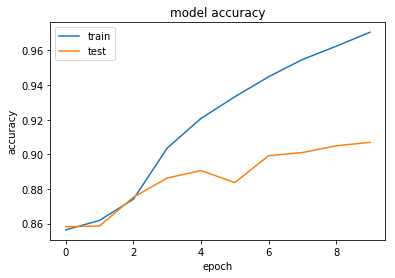

In [3]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

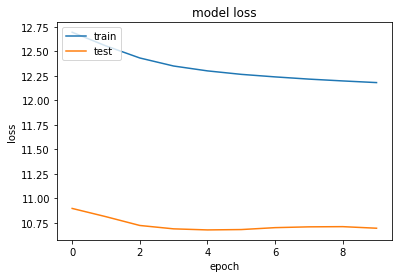

In [4]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [5]:
print(classification_report(y_true=actual,y_pred=predicted))


             precision    recall  f1-score   support

          D       0.73      0.65      0.69       976
          O       0.95      0.96      0.96     11713
          T       0.51      0.46      0.48       681

avg / total       0.91      0.91      0.91     13370



In [11]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  637   282    57]
 [  199 11269   245]
 [   33   335   313]]


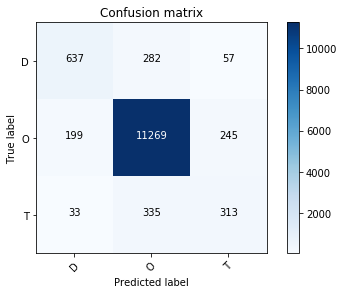

In [15]:
cnf_matrix = confusion_matrix(actual, predicted)
plot_confusion_matrix(cnf_matrix, classes=tags,
                      title='Confusion matrix')
# plt.figure()
plt.show()